In [1]:
import os
import scipy.io as sio
import scipy.misc as smisc
import numpy as np
import re as regexp
import math
import matplotlib.pyplot as plt
import scipy

from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from skimage import data, img_as_float

import scipy.io
import time
import glob,os
import cv2
from scipy import optimize
from pylab import *

import imutils
import cv2
import csv

# This script is used to analysis results from global parameter search
Global parameter search jobs were processed on ACI server, with results saved and transferred to MSCdata.

In [6]:
path = '/srv/home/chenyu/JDDC/GlobalParSearch/Round3/*/*/*/*/10Frames_B1_results/'
num = len(glob.glob(path))
par_list = []
prec_x_list = []
prec_y_list = []
for i in range(len(glob.glob(path))):
    fullpath = glob.glob(path)[i]
    print(fullpath.split('/')[-6:-2])
    par_list.append(fullpath.split('/')[-6:-2])
    csvfile = fullpath + 'bump-0_003-centers.csv'
    txtfile = fullpath + 'bump-0_003.txt'
    prec = FindPrecision(csvfile,txtfile,0.6,18)
    print(prec)
    prec_x_list.append(prec[0])
    prec_y_list.append(prec[1])

['0.3', '10', '250', '0.75']
(0.15303804147070083, 0.2364161662163626)
['0.3', '10', '250', '0.25']
(0.16966133772353825, 0.23036580331212322)
['0.3', '10', '250', '0.01']
(0.1877810921676626, 0.2293175566023894)
['0.3', '10', '250', '0.1']
(0.16152828404400774, 0.22891798300387048)
['0.3', '10', '250', '0.5']
(0.1601363446976999, 0.23129512128320387)
['0.3', '10', '300', '0.75']
(0.16579398143492838, 0.23466715858053916)
['0.3', '10', '300', '0.25']
(0.17081262179077478, 0.22531669694870687)
['0.3', '10', '300', '0.01']
(0.18006558994897853, 0.2259140268417944)
['0.3', '10', '300', '0.1']
(0.17680119866049895, 0.2316573563271498)
['0.3', '10', '300', '0.5']
(0.1516422720906252, 0.23232231474701667)
['0.3', '10', '350', '0.75']
(0.17063185141942586, 0.2361303082451993)
['0.3', '10', '350', '0.25']
(0.17823113703451676, 0.22702379159805527)
['0.3', '10', '350', '0.01']
(0.18589778379638516, 0.2246607479463651)
['0.3', '10', '350', '0.1']
(0.1712838338848225, 0.22718748285369494)
['0.3',

In [7]:
symmetric_path = '/srv/home/chenyu/JDDC/GlobalParSearch/NewResults/SymmetricGaussian/'
csvfile = symmetric_path + 'bump-0_003-centers.csv'
txtfile = symmetric_path + 'bump-0_003.txt'
prec = FindPrecision(csvfile,txtfile,0.6,18)
print(prec)

(0.15379149081594978, 0.25083203612657695)


In [8]:
sorted(zip(prec_x_list, prec_y_list,par_list))

[(0.1516422720906252, 0.23232231474701667, ['0.3', '10', '300', '0.5']),
 (0.15303804147070083, 0.2364161662163626, ['0.3', '10', '250', '0.75']),
 (0.15886993091067309, 0.23828068443702796, ['0.3', '10', '400', '0.75']),
 (0.1601363446976999, 0.23129512128320387, ['0.3', '10', '250', '0.5']),
 (0.16152828404400774, 0.22891798300387048, ['0.3', '10', '250', '0.1']),
 (0.16403160720807863, 0.23459396767437155, ['0.3', '10', '400', '0.5']),
 (0.16579398143492838, 0.23466715858053916, ['0.3', '10', '300', '0.75']),
 (0.16966133772353825, 0.23036580331212322, ['0.3', '10', '250', '0.25']),
 (0.17063185141942586, 0.2361303082451993, ['0.3', '10', '350', '0.75']),
 (0.17081262179077478, 0.22531669694870687, ['0.3', '10', '300', '0.25']),
 (0.1712838338848225, 0.22718748285369494, ['0.3', '10', '350', '0.1']),
 (0.1753496039015641, 0.22974453670699715, ['0.3', '10', '400', '0.25']),
 (0.17552632919089042, 0.22577610220447103, ['0.3', '10', '350', '0.5']),
 (0.17680119866049895, 0.231657356327

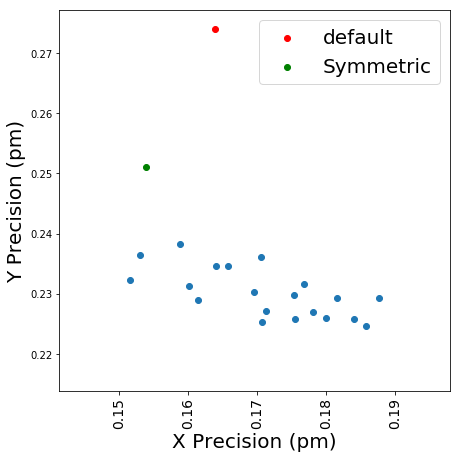

In [9]:
fig, ax = plt.subplots(figsize=(7,7))
plt.scatter(np.asarray(prec_x_list), np.asarray(prec_y_list))
plt.ylabel('Y Precision (pm)',fontsize=20)
plt.xlabel('X Precision (pm)',fontsize=20)
plt.xticks(fontsize=14, rotation=90)
plt.scatter(0.164,0.274,c='r',label='default')
plt.scatter(0.154,0.251,c='g',label='Symmetric')
plt.legend(fontsize=20)

<IPython.core.display.Javascript object>


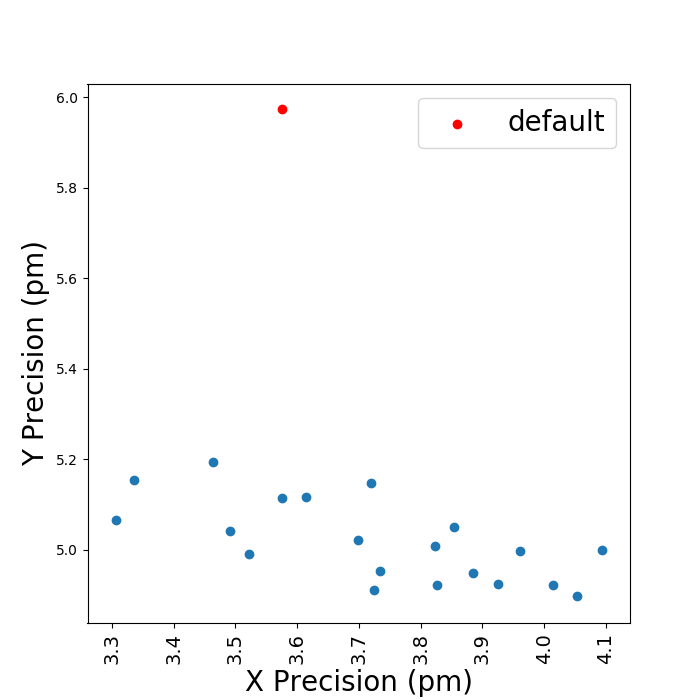

In [10]:
# plt.scatter(np.linspace(1,500,500),prec_x_list)
# plt.scatter(np.linspace(1,500,500),prec_y_list)
# par_sorted = [x for _,x in sorted(zip(prec_x_list,par_list))]
# print(par_sorted)
%matplotlib notebook
fig, ax = plt.subplots(figsize=(7,7))
plt.scatter(np.asarray(prec_x_list)*21.8, np.asarray(prec_y_list)*21.8)
plt.ylabel('Y Precision (pm)',fontsize=20)
plt.xlabel('X Precision (pm)',fontsize=20)
plt.xticks(fontsize=14, rotation=90)
plt.scatter(0.164*21.8,0.274*21.8,c='r',label='default')
plt.legend(fontsize=20)

In [3]:
def FindPrecision(csvFileName,txtFileName,threshold,separation):
    start = 0
    with open(csvFileName) as csvfile:
        file=csv.reader(open(csvFileName,'r'))
        peaks_x = []
        peaks_y = []
        for row in file:
            if start == 0:
                start = 1
                continue
            peaks_x.append(float(row[0]))
            peaks_y.append(float(row[1]))

    with open(txtFileName) as f:
        content = f.readlines()
    # you may also want to remove whitespace characters like `\n` at the end of each line
    content = [x.strip() for x in content];

    peaks_int = []
    for i in range(len(peaks_x)):
        peaks_int.append(float(content[i*3+2]))
        
    array_x = np.asarray(peaks_x)
    array_y = np.asarray(peaks_y)
    array_int = np.asarray(peaks_int)
    index = np.where((array_x>10) & (array_x<140) & (array_y > 10) & (array_y < 140))
    array_x = array_x[index]
    array_y = array_y[index]
    array_int = array_int[index]
        
    lattice1 = np.where(array_int>threshold)
    array_x1 = array_x[lattice1]
    array_y1 = array_y[lattice1]
    array_int1 = array_int[lattice1]

    return FindYStd(array_x1,array_y1,separation),FindXStd(array_x1,array_y1,separation)

In [4]:
def FindYStd(array_x1_copy,array_y1_copy,separation):
    y_sep = []
    while array_x1_copy.size != 0:
        x_cor = array_x1_copy[0]
        index = np.where((array_x1_copy<x_cor+3) & (array_x1_copy>x_cor-3))
        array_y_sub = array_y1_copy[index]
        array_y_sub = np.sort(array_y_sub)
        for i in range(array_y_sub.shape[0]-1):
            spacing = array_y_sub[i+1] - array_y_sub[i]
            if (spacing < separation + 5) & (spacing > separation -5):
                y_sep.append(spacing)
        array_x1_copy = np.delete(array_x1_copy,index)
        array_y1_copy = np.delete(array_y1_copy,index)

    y_std = np.std(np.asarray(y_sep))
    return y_std

In [5]:
def FindXStd(array_x1_copy,array_y1_copy,separation):
    x_sep = []
    while array_x1_copy.size != 0:
        y_cor = array_y1_copy[0]
        index = np.where((array_y1_copy<y_cor+3) & (array_y1_copy>y_cor-3))
        array_x_sub = array_x1_copy[index]
        array_x_sub = np.sort(array_x_sub)
        for i in range(array_x_sub.shape[0]-1):
            spacing = array_x_sub[i+1] - array_x_sub[i]
            if (spacing < separation + 5) & (spacing > separation -5):
                x_sep.append(array_x_sub[i+1] - array_x_sub[i])
        array_x1_copy = np.delete(array_x1_copy,index)
        array_y1_copy = np.delete(array_y1_copy,index)

    x_std = np.std(np.asarray(x_sep))
    return x_std